# Calibrating PKPD Model to AL TES Data from [Bassat et al., 2009](https://pubmed.ncbi.nlm.nih.gov/19936217/) and [Baraka et al., 2014](https://journals.asm.org/doi/10.1128/aac.03647-14)

## **Drug:** AL

### **Gene locus and Allele:** pfmdr1 N86

**Number of patients in arm:** 56

**Number of patients cured:** 49

**Efficacy:** 0.875 or 87.5%


### **Gene locus and Allele:** pfmdr1 86Y
**Number of patients in arm:** 35

**Number of patients cured:** 35

**Efficacy:** 1 or 100%


### **Gene locus and Allele:** pfcrt K76
**Number of patients in arm:** 27

**Number of patients cured:** 25

**Efficacy:** 0.9259 or 92.59%


### **Gene locus and Allele:** pfcrt 76T
**Number of patients in arm:** 62

**Number of patients cured:** 57

**Efficacy:** 0.9194 or 91.94%


<br>
<br>
<br>

# Calibration 1: Calibraring pmax_art with pmax_lum at 0

<br>

## Test 1: Number of Patients = 100
## Range of pmax_art = 0.80001 to 0.99997
## Number of pmax_art values tested = 50

In [ ]:
import subprocess
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

In [67]:
# Define the range for pmax_art
min_pmax = 0.99997
max_pmax = 0.80001

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 50)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

print(pmax_values)

[0.99997    0.99588918 0.99180837 0.98772755 0.98364673 0.97956592
 0.9754851  0.97140429 0.96732347 0.96324265 0.95916184 0.95508102
 0.9510002  0.94691939 0.94283857 0.93875776 0.93467694 0.93059612
 0.92651531 0.92243449 0.91835367 0.91427286 0.91019204 0.90611122
 0.90203041 0.89794959 0.89386878 0.88978796 0.88570714 0.88162633
 0.87754551 0.87346469 0.86938388 0.86530306 0.86122224 0.85714143
 0.85306061 0.8489798  0.84489898 0.84081816 0.83673735 0.83265653
 0.82857571 0.8244949  0.82041408 0.81633327 0.81225245 0.80817163
 0.80409082 0.80001   ]


In [5]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "100",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_art_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_art_adj = result
            results.append((idx, efficacy))
            if df_pmax_art_adj is not None:
                dfs.append(df_pmax_art_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_test_01_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_pmax_art_test_01_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_01_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [00:11<00:00,  4.18it/s]

DataFrame saved as pickle and CSV files successfully.


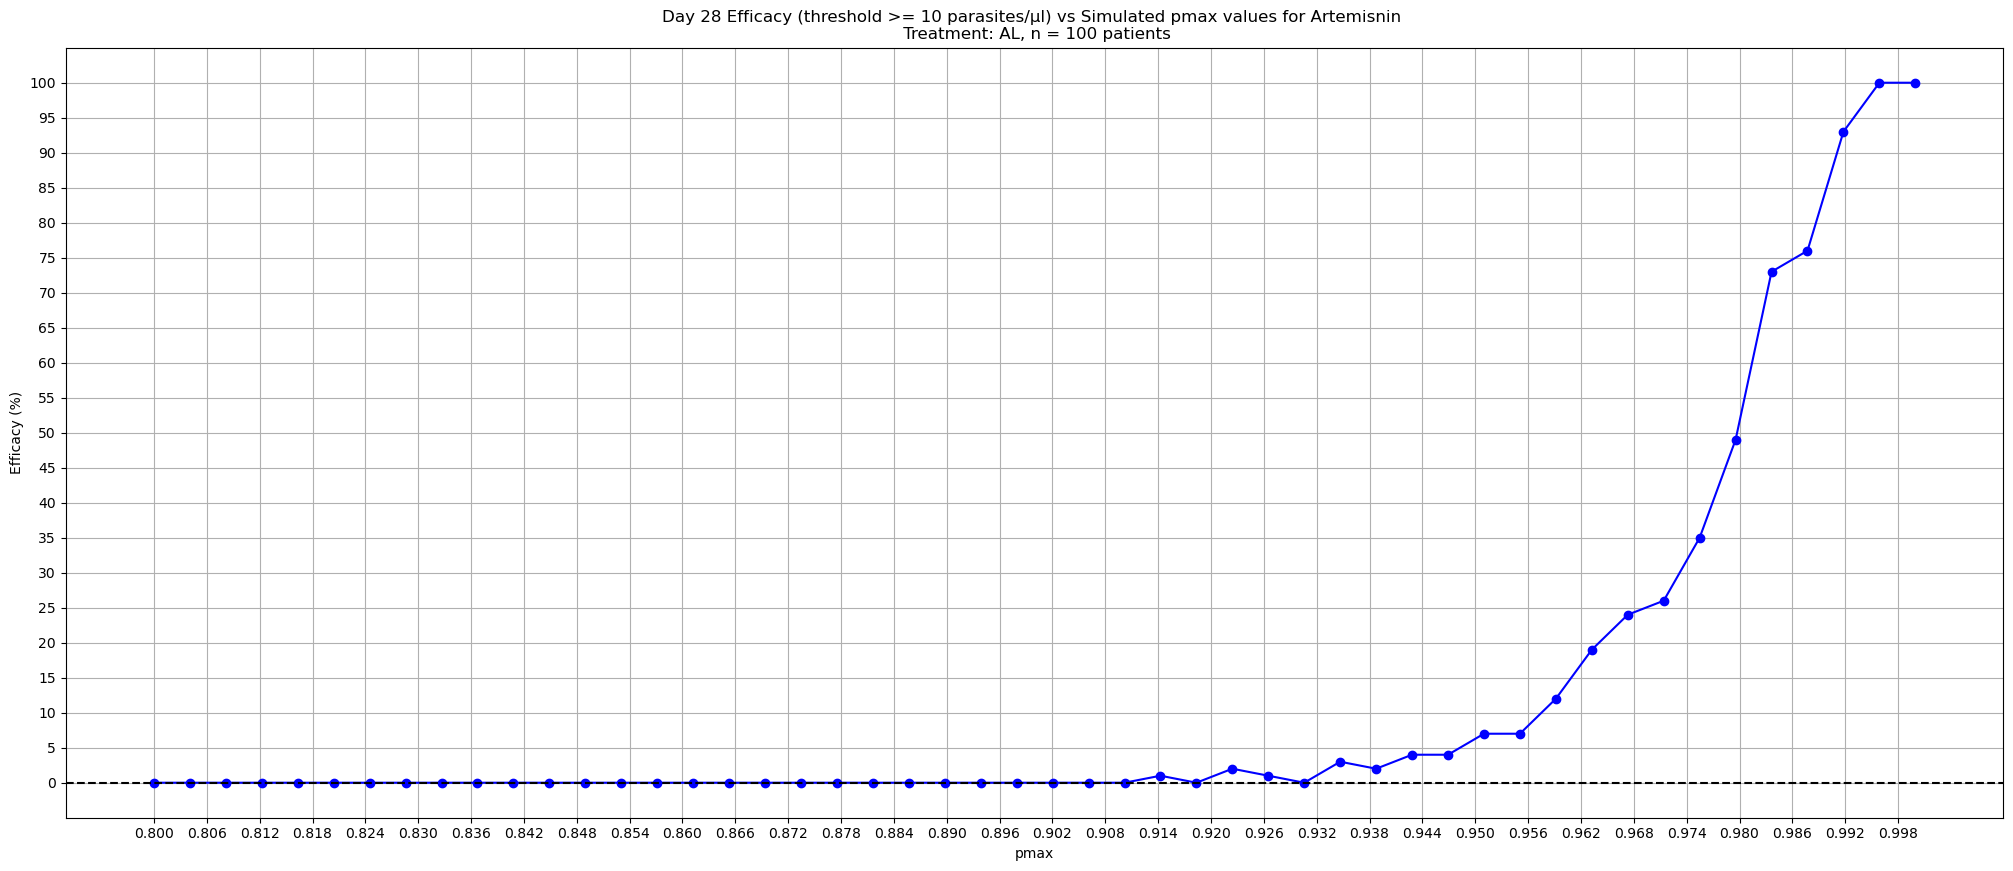

In [ ]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.80001 to 0.99997')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 100 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.006))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_01_efficacy.png")  # Save the plot as a PNG file
plt.show()

<br>

## Test 2: Number of Patients = 1000
## Range of pmax_art = 0.80001 to 0.99997
## Number of pmax_art values tested = 50

In [7]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_art_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_art_adj = result
            results.append((idx, efficacy))
            if df_pmax_art_adj is not None:
                dfs.append(df_pmax_art_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the efficacy DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_test_02_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_pmax_art_test_02_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_02_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [02:49<00:00,  3.39s/it]  

DataFrame saved as pickle and CSV files successfully.


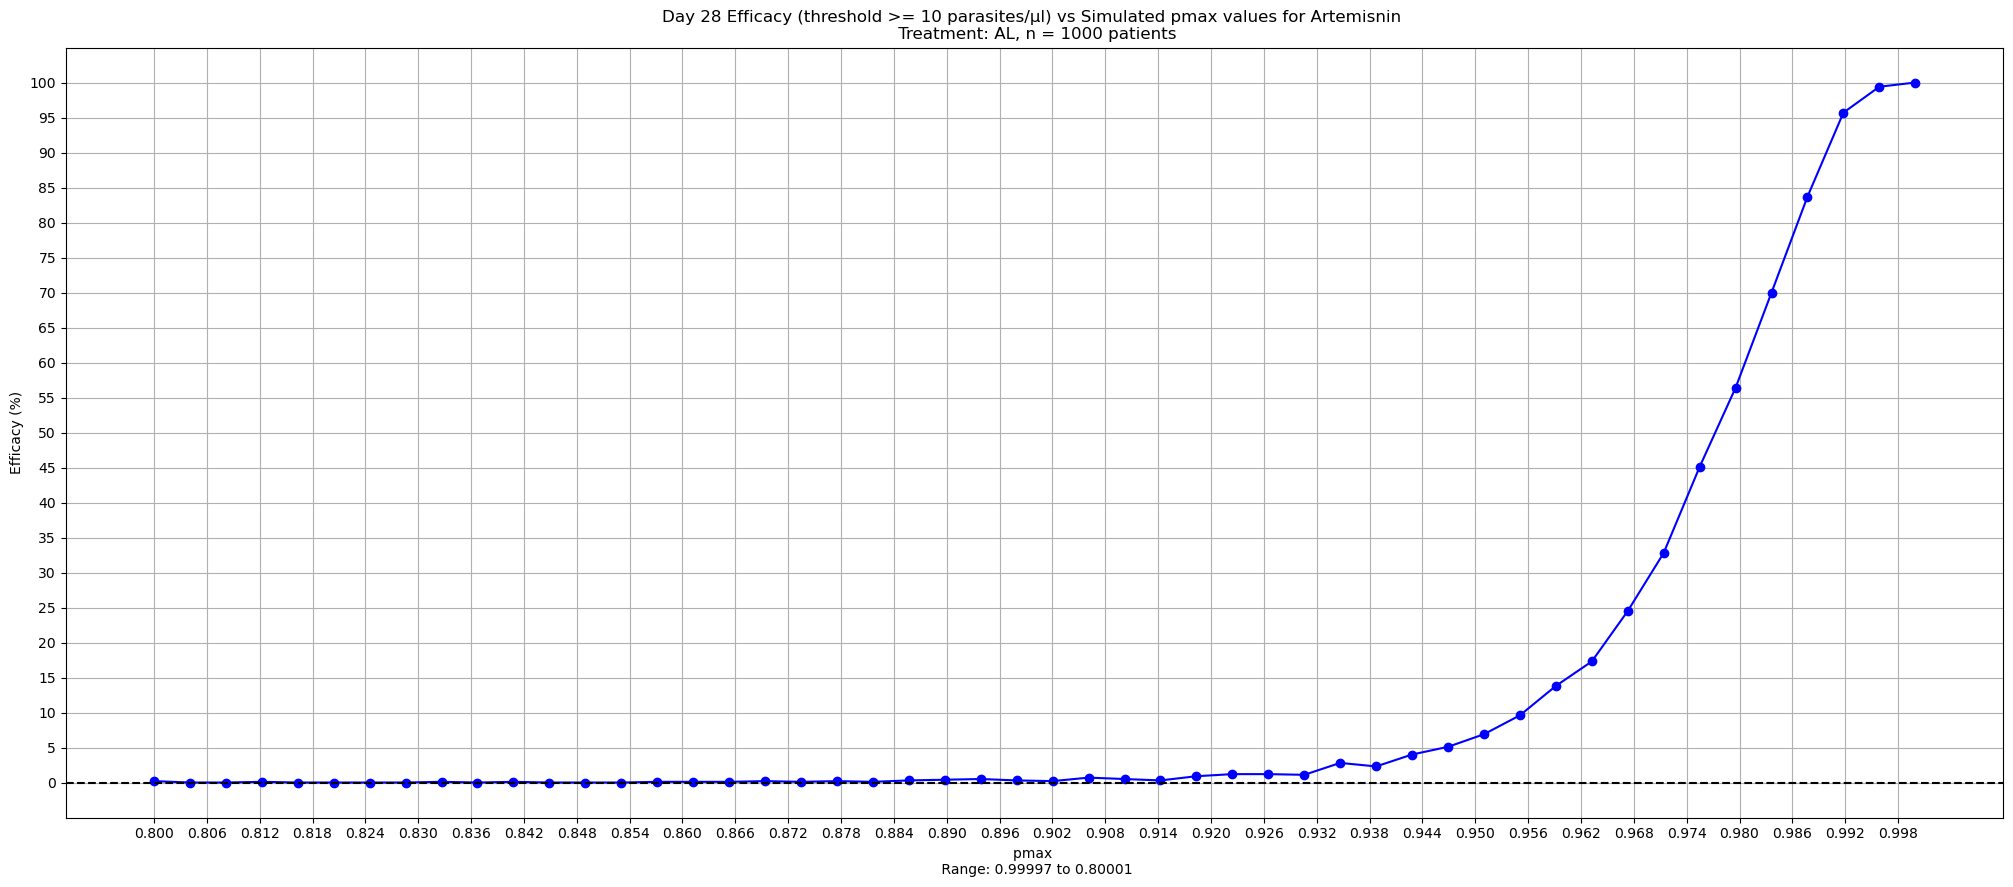

In [ ]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.80001 to 0.99997')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.006))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_02_efficacy.png")  # Save the plot as a PNG file
plt.show()

In [ ]:
df

,pmax_art,efficacy
0,0.999970,100.0
1,0.995889,99.4
2,0.991808,95.7
3,0.987728,83.7
4,0.983647,70.0
5,0.979566,56.4
6,0.975485,45.1
7,0.971404,32.8
8,0.967323,24.5
9,0.963243,17.3


Text(0.5, 0, 'Parasite Density')

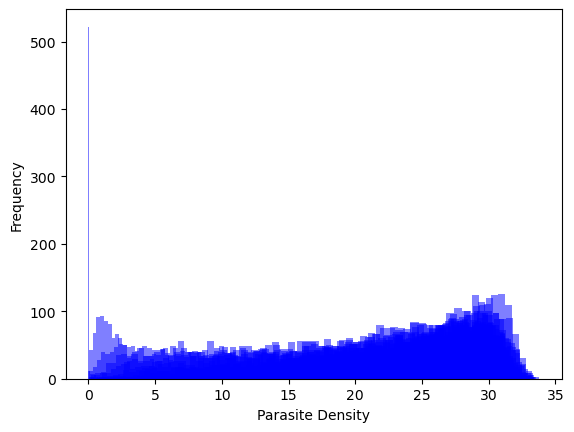

In [15]:
for i in range(50):
    dfs[i]['PARASITEDENSITY'].plot.hist(bins=50, alpha=0.5, color='b', label=f'pmax_art = {pmax_values[i]}')
plt.xlabel('Parasite Density')

<br>

## Test 3: Number of Patients = 10000
## Range of pmax_art = 0.80001 to 0.99997
## Number of pmax_art values tested = 50

In [68]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_art_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_art_adj = result
            results.append((idx, efficacy))
            if df_pmax_art_adj is not None:
                dfs.append(df_pmax_art_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the efficacy DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_test_03_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_pmax_art_test_03_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_03_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [32:39<00:00, 39.18s/it]    

DataFrame saved as pickle and CSV files successfully.


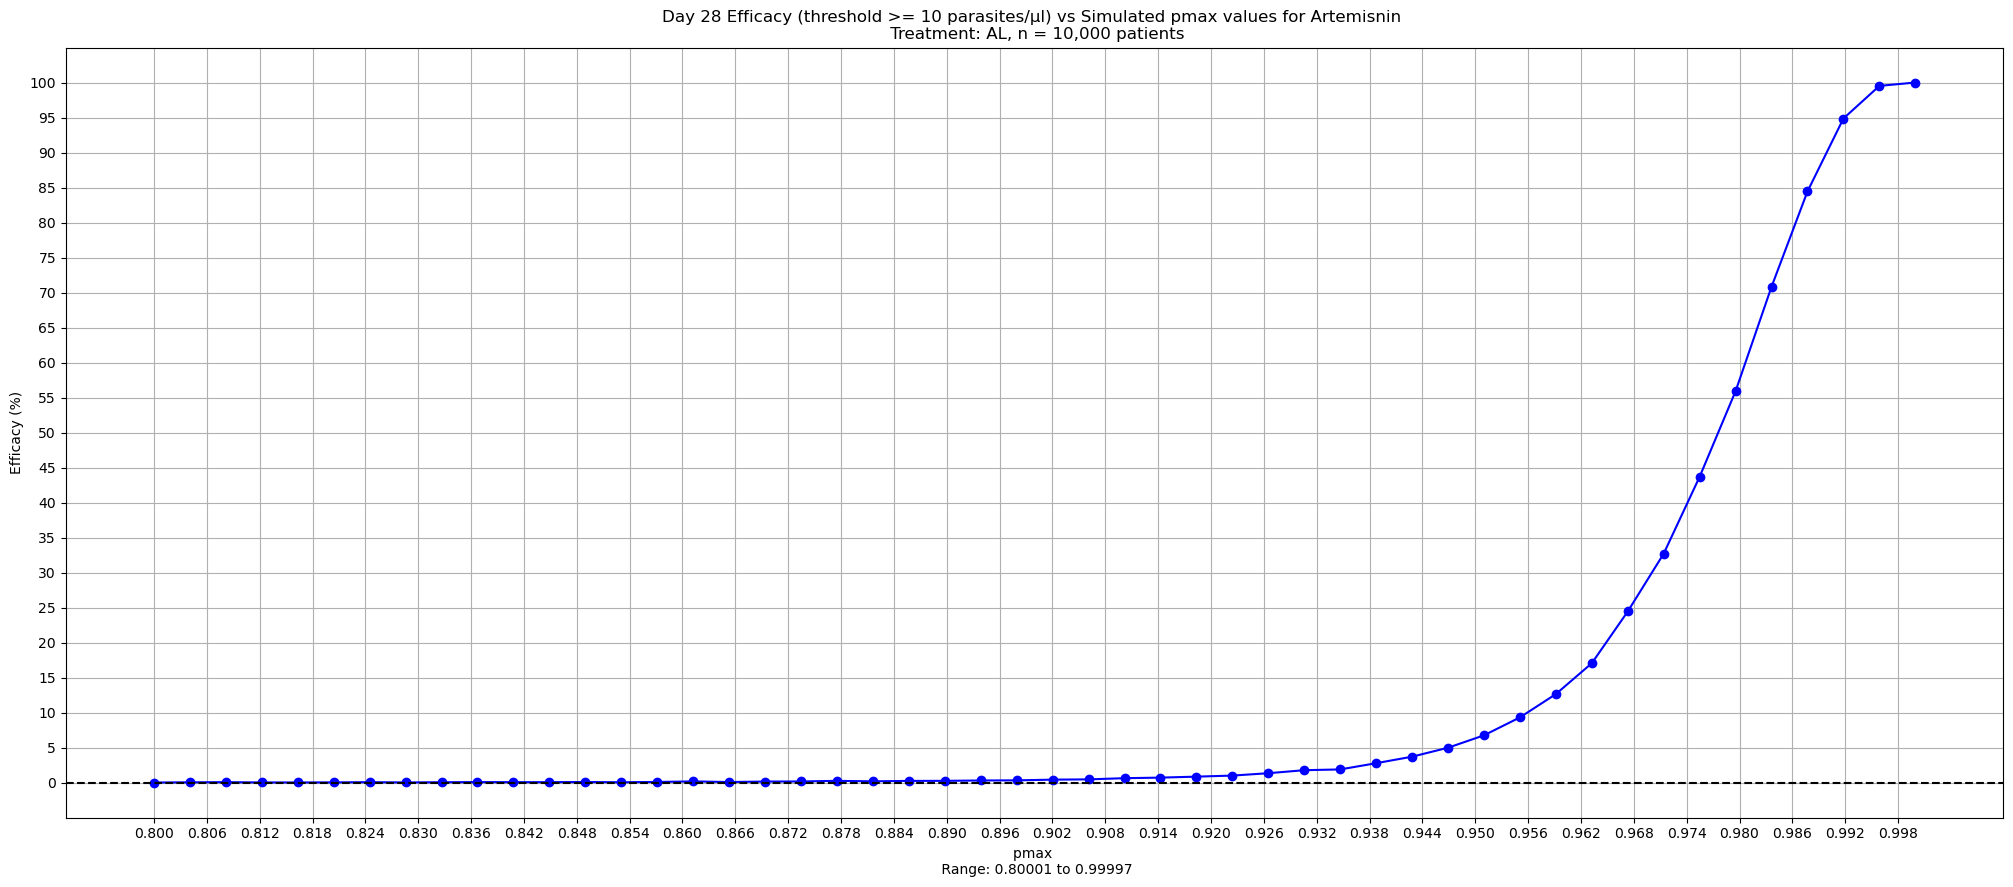

In [69]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.80001 to 0.99997')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 10,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.006))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_03_efficacy.png")  # Save the plot as a PNG file
plt.show()

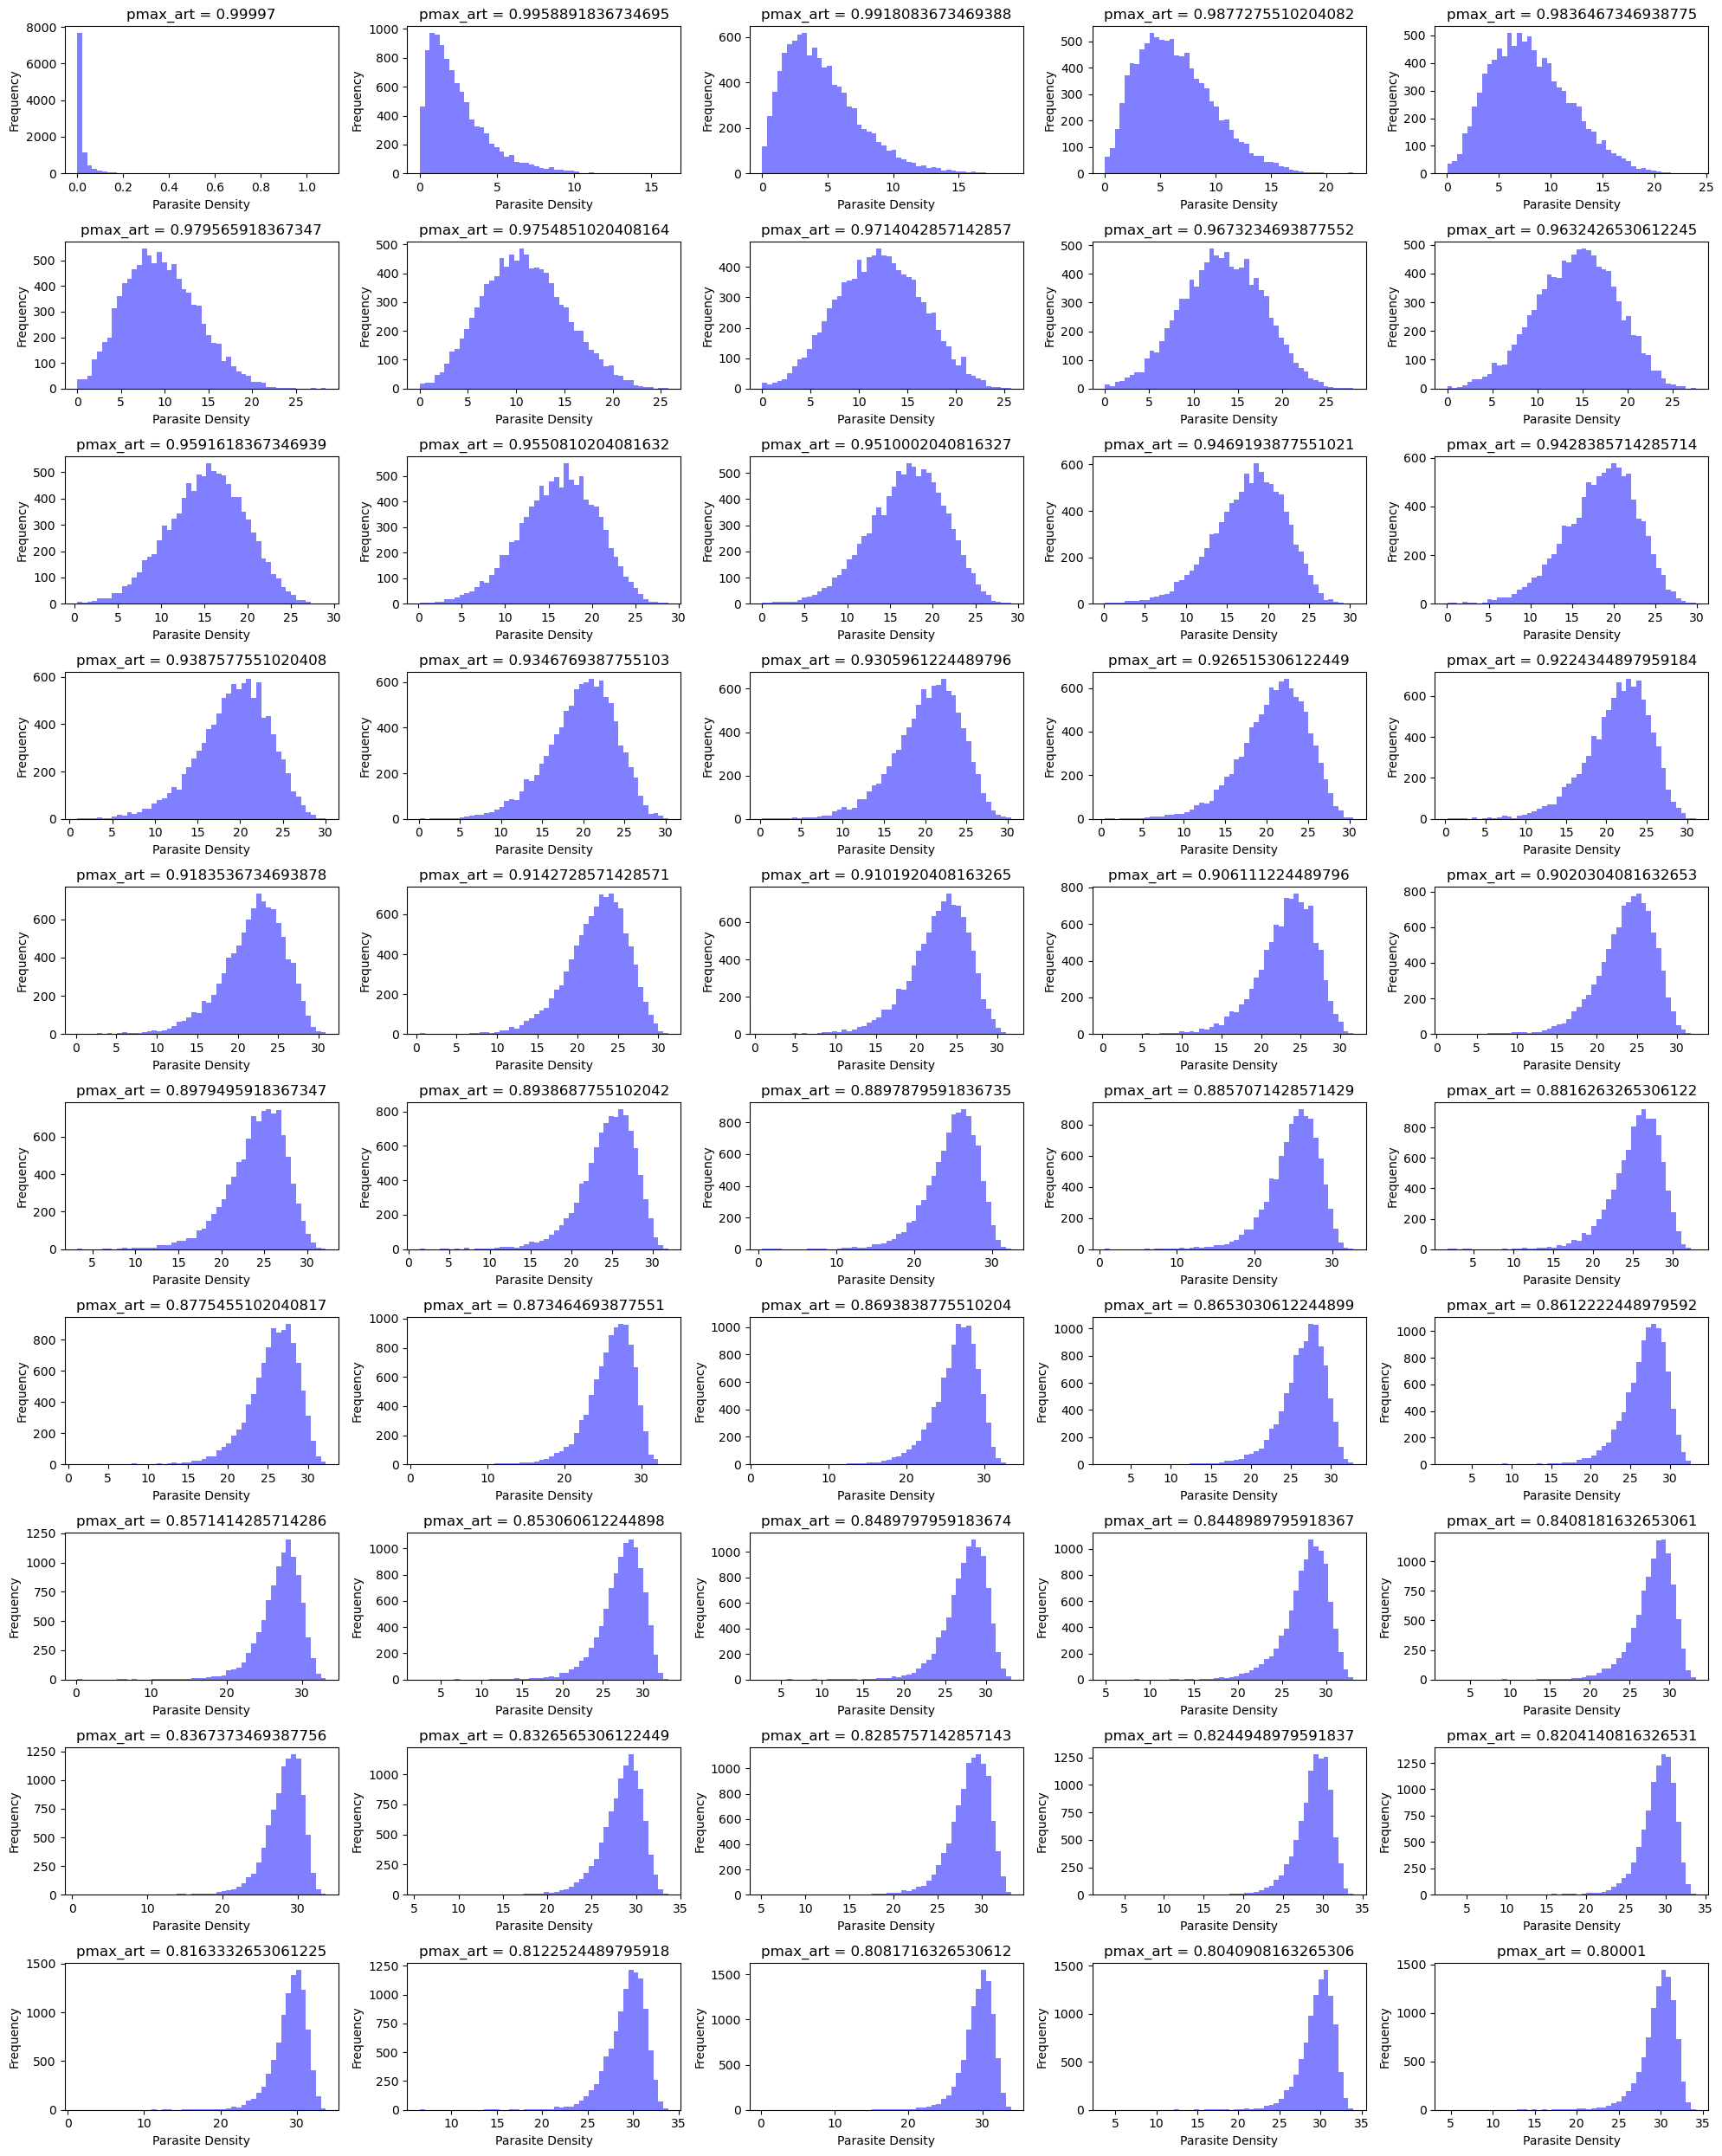

In [77]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20, 25))  # Create a 4x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i in range(50):
    ax = axes[i]
    dfs[i]['PARASITEDENSITY'].plot.hist(bins=50, alpha=0.5, color='b', ax=ax)
    ax.set_title(f'pmax_art = {pmax_values[i]}')
    ax.set_xlabel('Parasite Density')
    ax.set_ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig("pkpd_AL_pmax_art_test_03_parasite_density.png") 
plt.show()

<br>

## Test 4: Number of Patients = 10000
## Range of pmax_art = 0.950 to 0.99997
## Number of pmax_art values tested = 20

In [19]:
# Define the range for pmax_art
min_pmax = 0.99997
max_pmax = 0.950

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 20)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

print(pmax_values)

[0.99997 0.99734 0.99471 0.99208 0.98945 0.98682 0.98419 0.98156 0.97893
 0.9763  0.97367 0.97104 0.96841 0.96578 0.96315 0.96052 0.95789 0.95526
 0.95263 0.95   ]


In [20]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_art_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_art_adj = result
            results.append((idx, efficacy))
            if df_pmax_art_adj is not None:
                dfs.append(df_pmax_art_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the efficacy DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_test_04_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_pmax_art_test_04_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_04_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 20/20 [16:03<00:00, 48.19s/it]  

DataFrame saved as pickle and CSV files successfully.


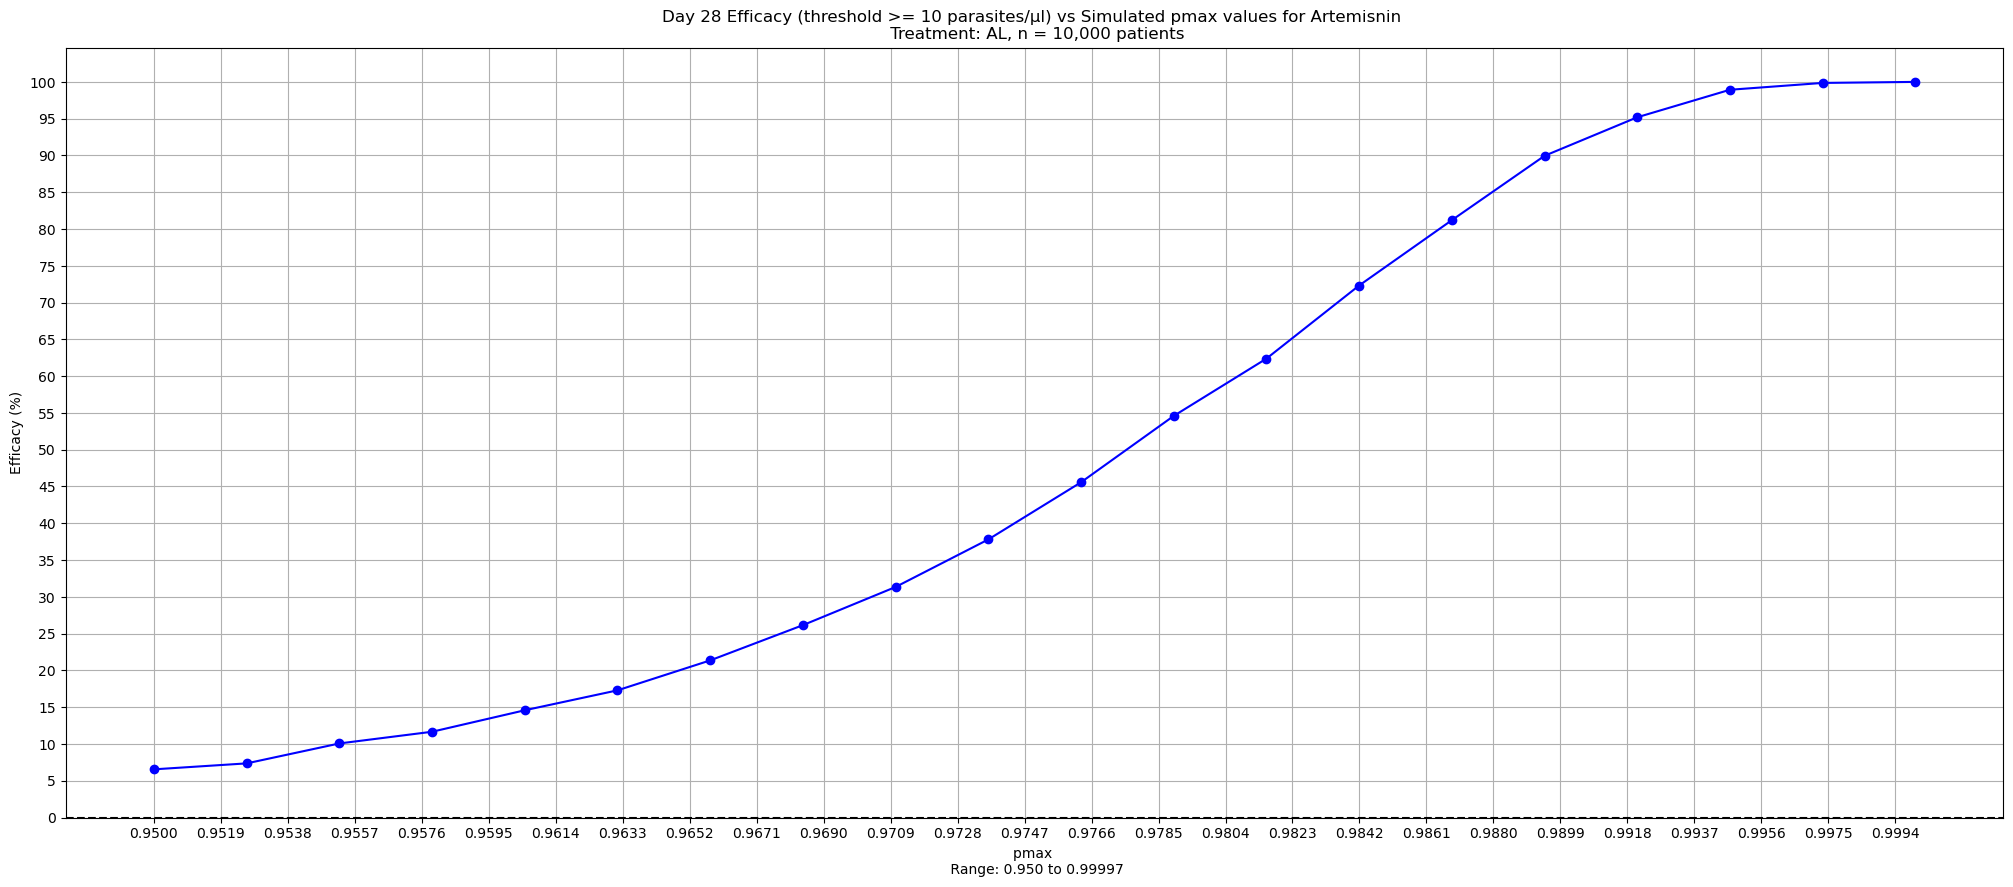

In [33]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.950 to 0.99997')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 10,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values)+0.001, 0.0019))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_04_efficacy.png")  # Save the plot as a PNG file
plt.show()

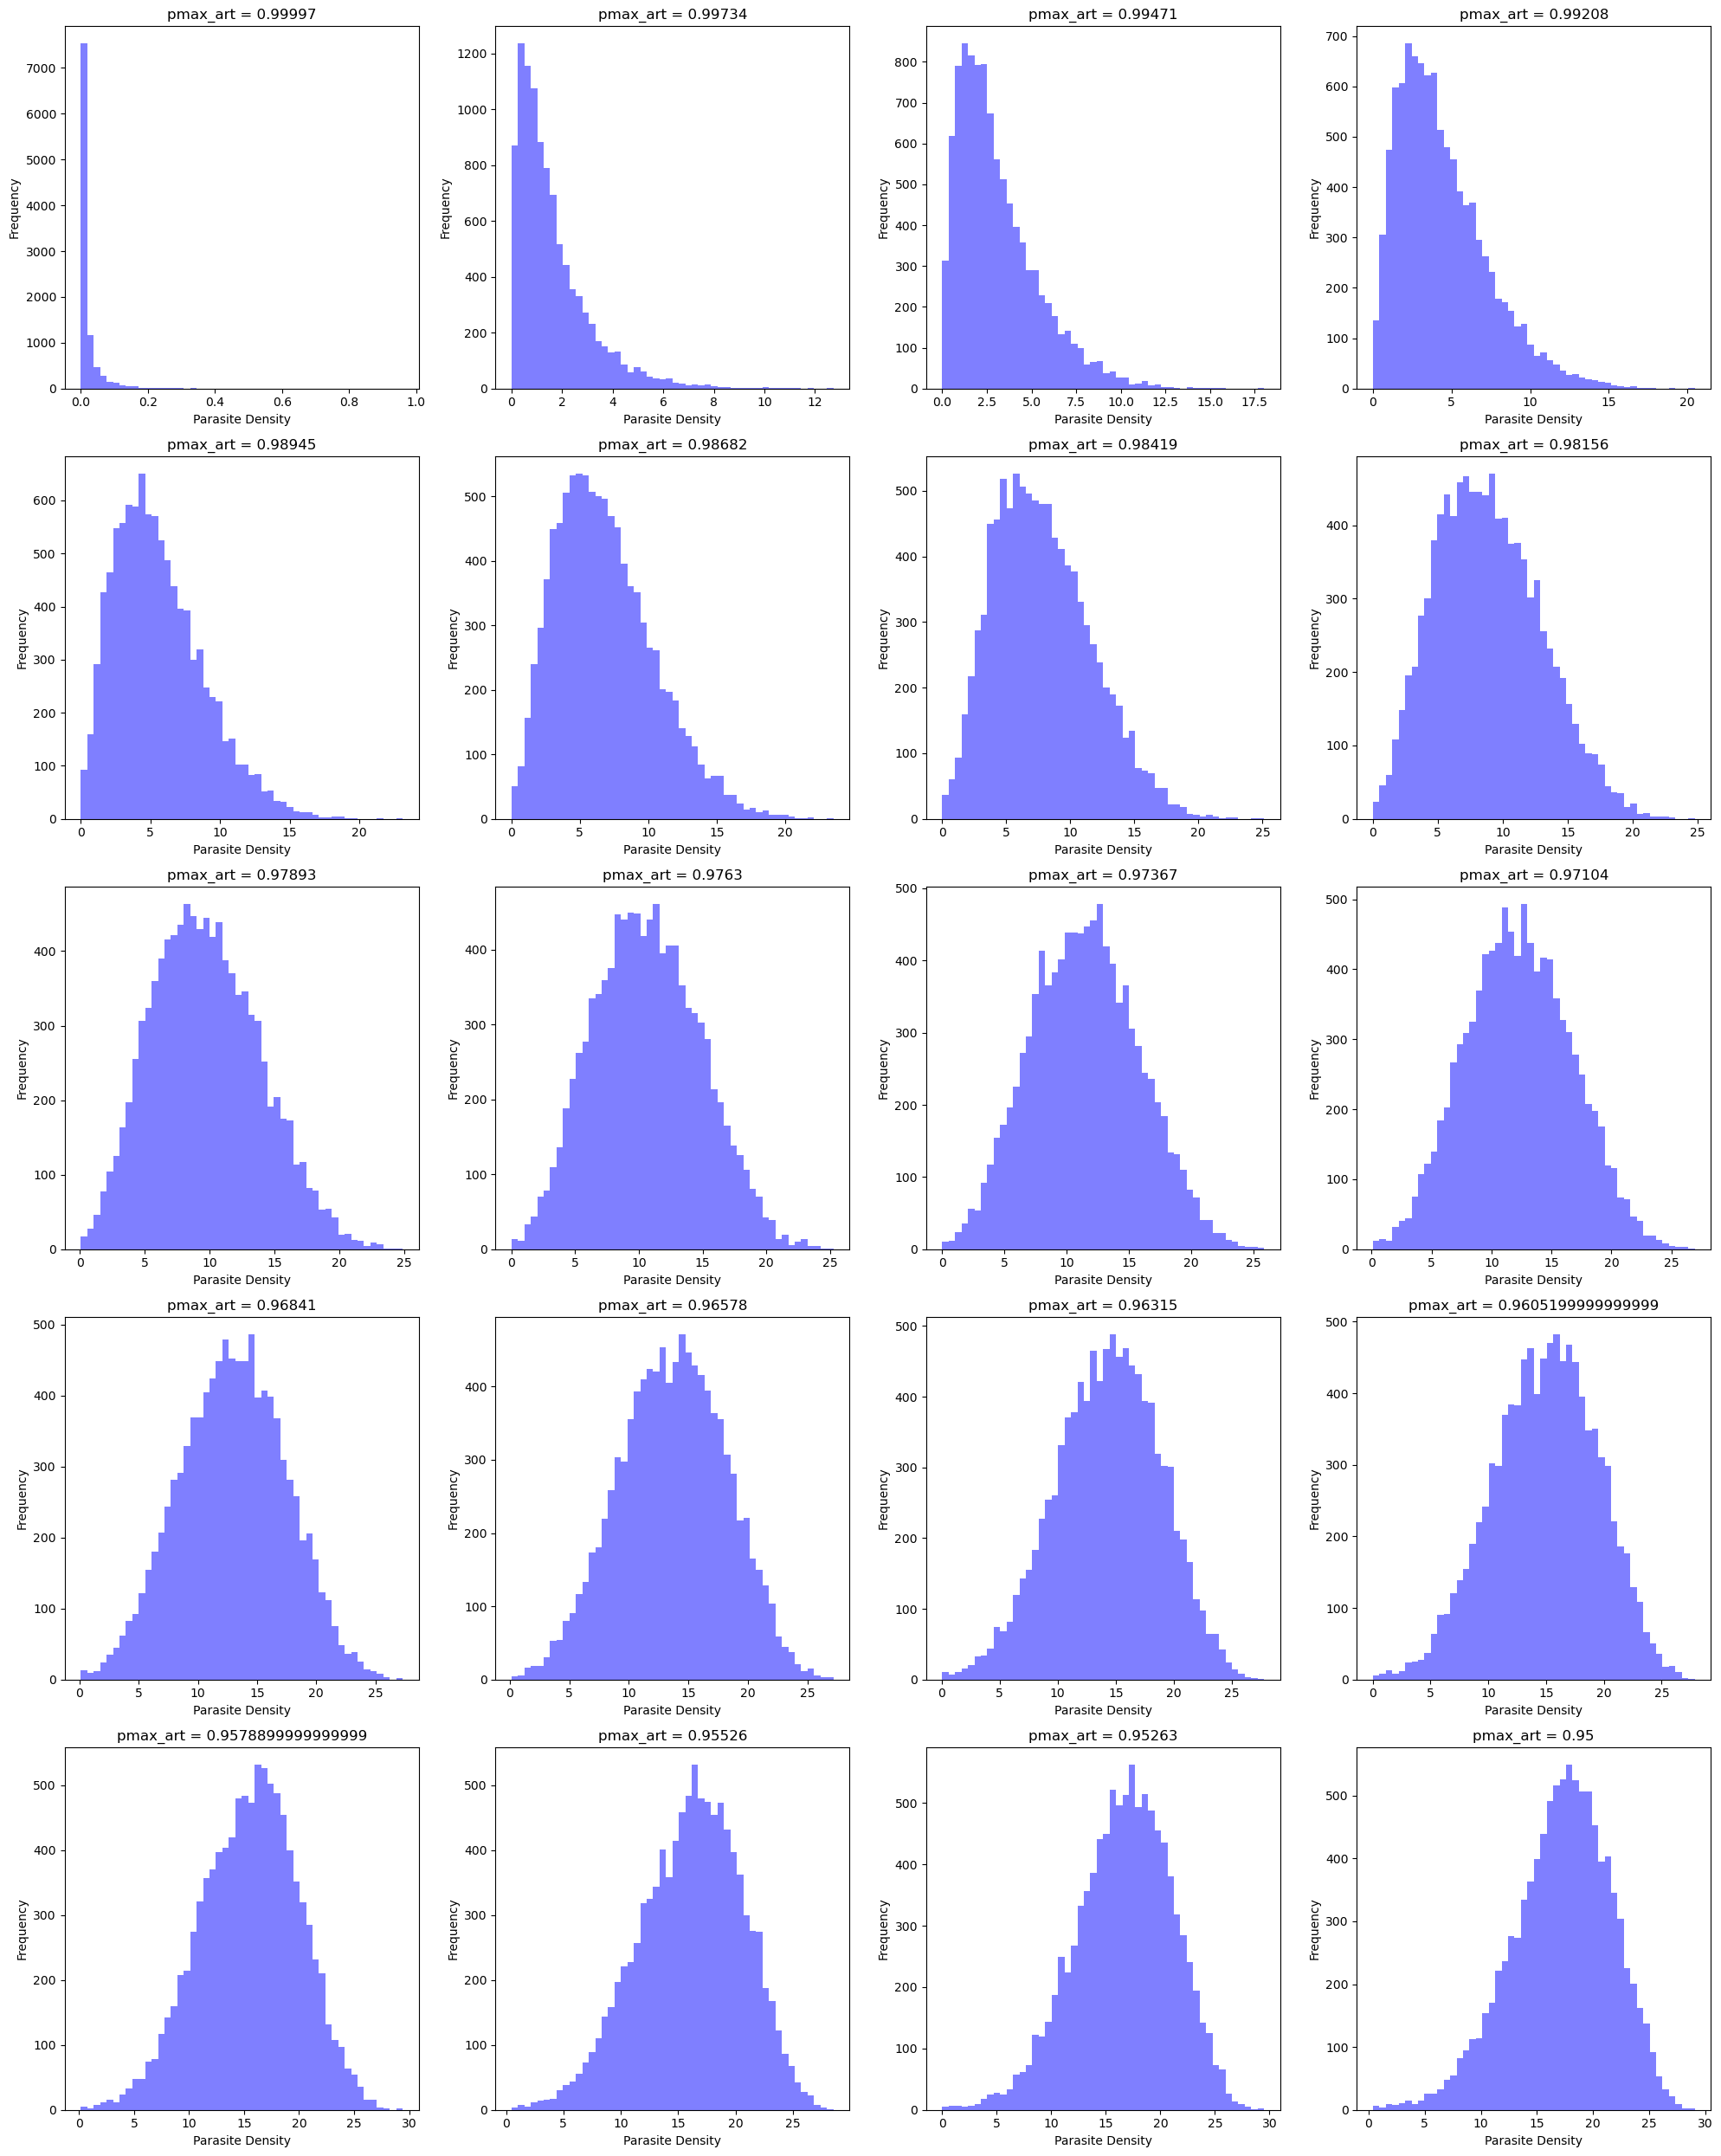

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))  # Create a 4x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i in range(20):
    ax = axes[i]
    dfs[i]['PARASITEDENSITY'].plot.hist(bins=50, alpha=0.5, color='b', ax=ax)
    ax.set_title(f'pmax_art = {pmax_values[i]}')
    ax.set_xlabel('Parasite Density')
    ax.set_ylabel('Frequency')

pplt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig("pkpd_AL_pmax_art_test_04_parasite_density.png") 
plt.show()

<br>

## Test 5: Number of Patients = 10000
## Range of pmax_art = 0.97 to 0.98
## Number of pmax_art values tested = 20

In [ ]:
# Define the range for pmax_art
min_pmax = 0.983
max_pmax = 0.982

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 20) 

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

print(pmax_values)

[0.9899     0.98937895 0.98885789 0.98833684 0.98781579 0.98729474
 0.98677368 0.98625263 0.98573158 0.98521053 0.98468947 0.98416842
 0.98364737 0.98312632 0.98260526 0.98208421 0.98156316 0.98104211
 0.98052105 0.98      ]


In [61]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_art_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_art_adj = result
            results.append((idx, efficacy))
            if df_pmax_art_adj is not None:
                dfs.append(df_pmax_art_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the efficacy DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_test_05_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_pmax_art_test_05_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_05_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 20/20 [16:22<00:00, 49.15s/it]  

DataFrame saved as pickle and CSV files successfully.


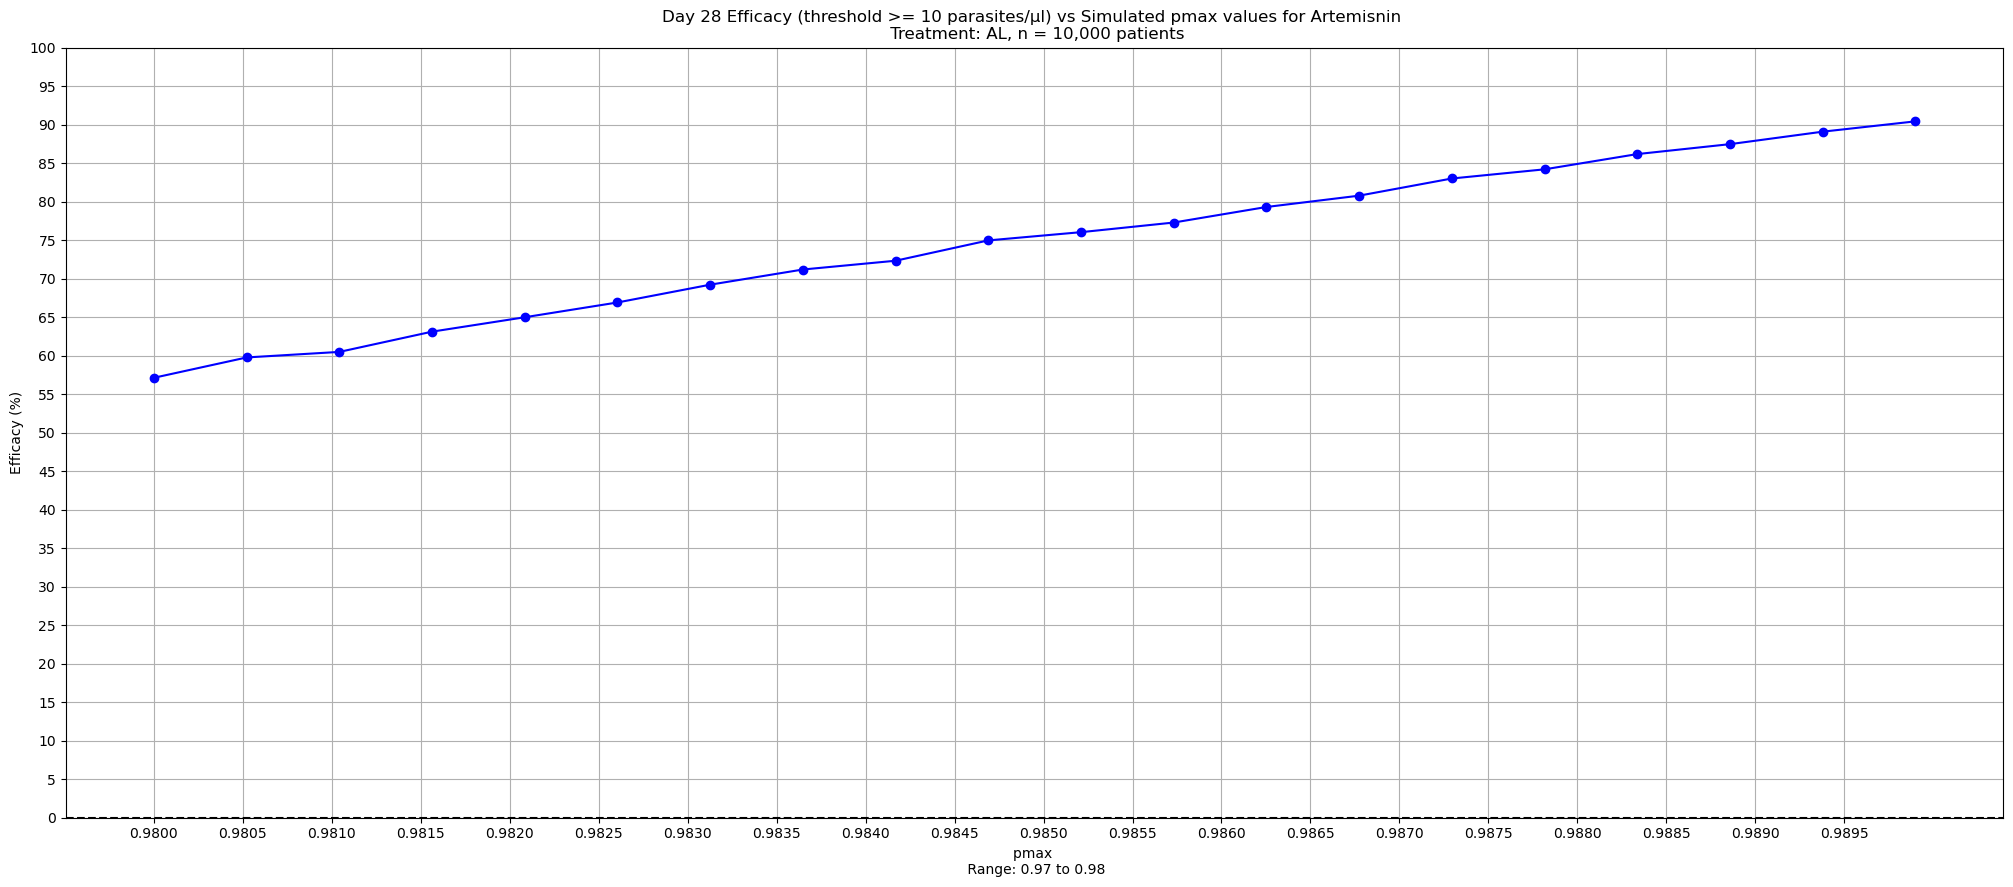

In [64]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.97 to 0.98')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 10,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.0005))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_05_efficacy.png")  # Save the plot as a PNG file
plt.show()

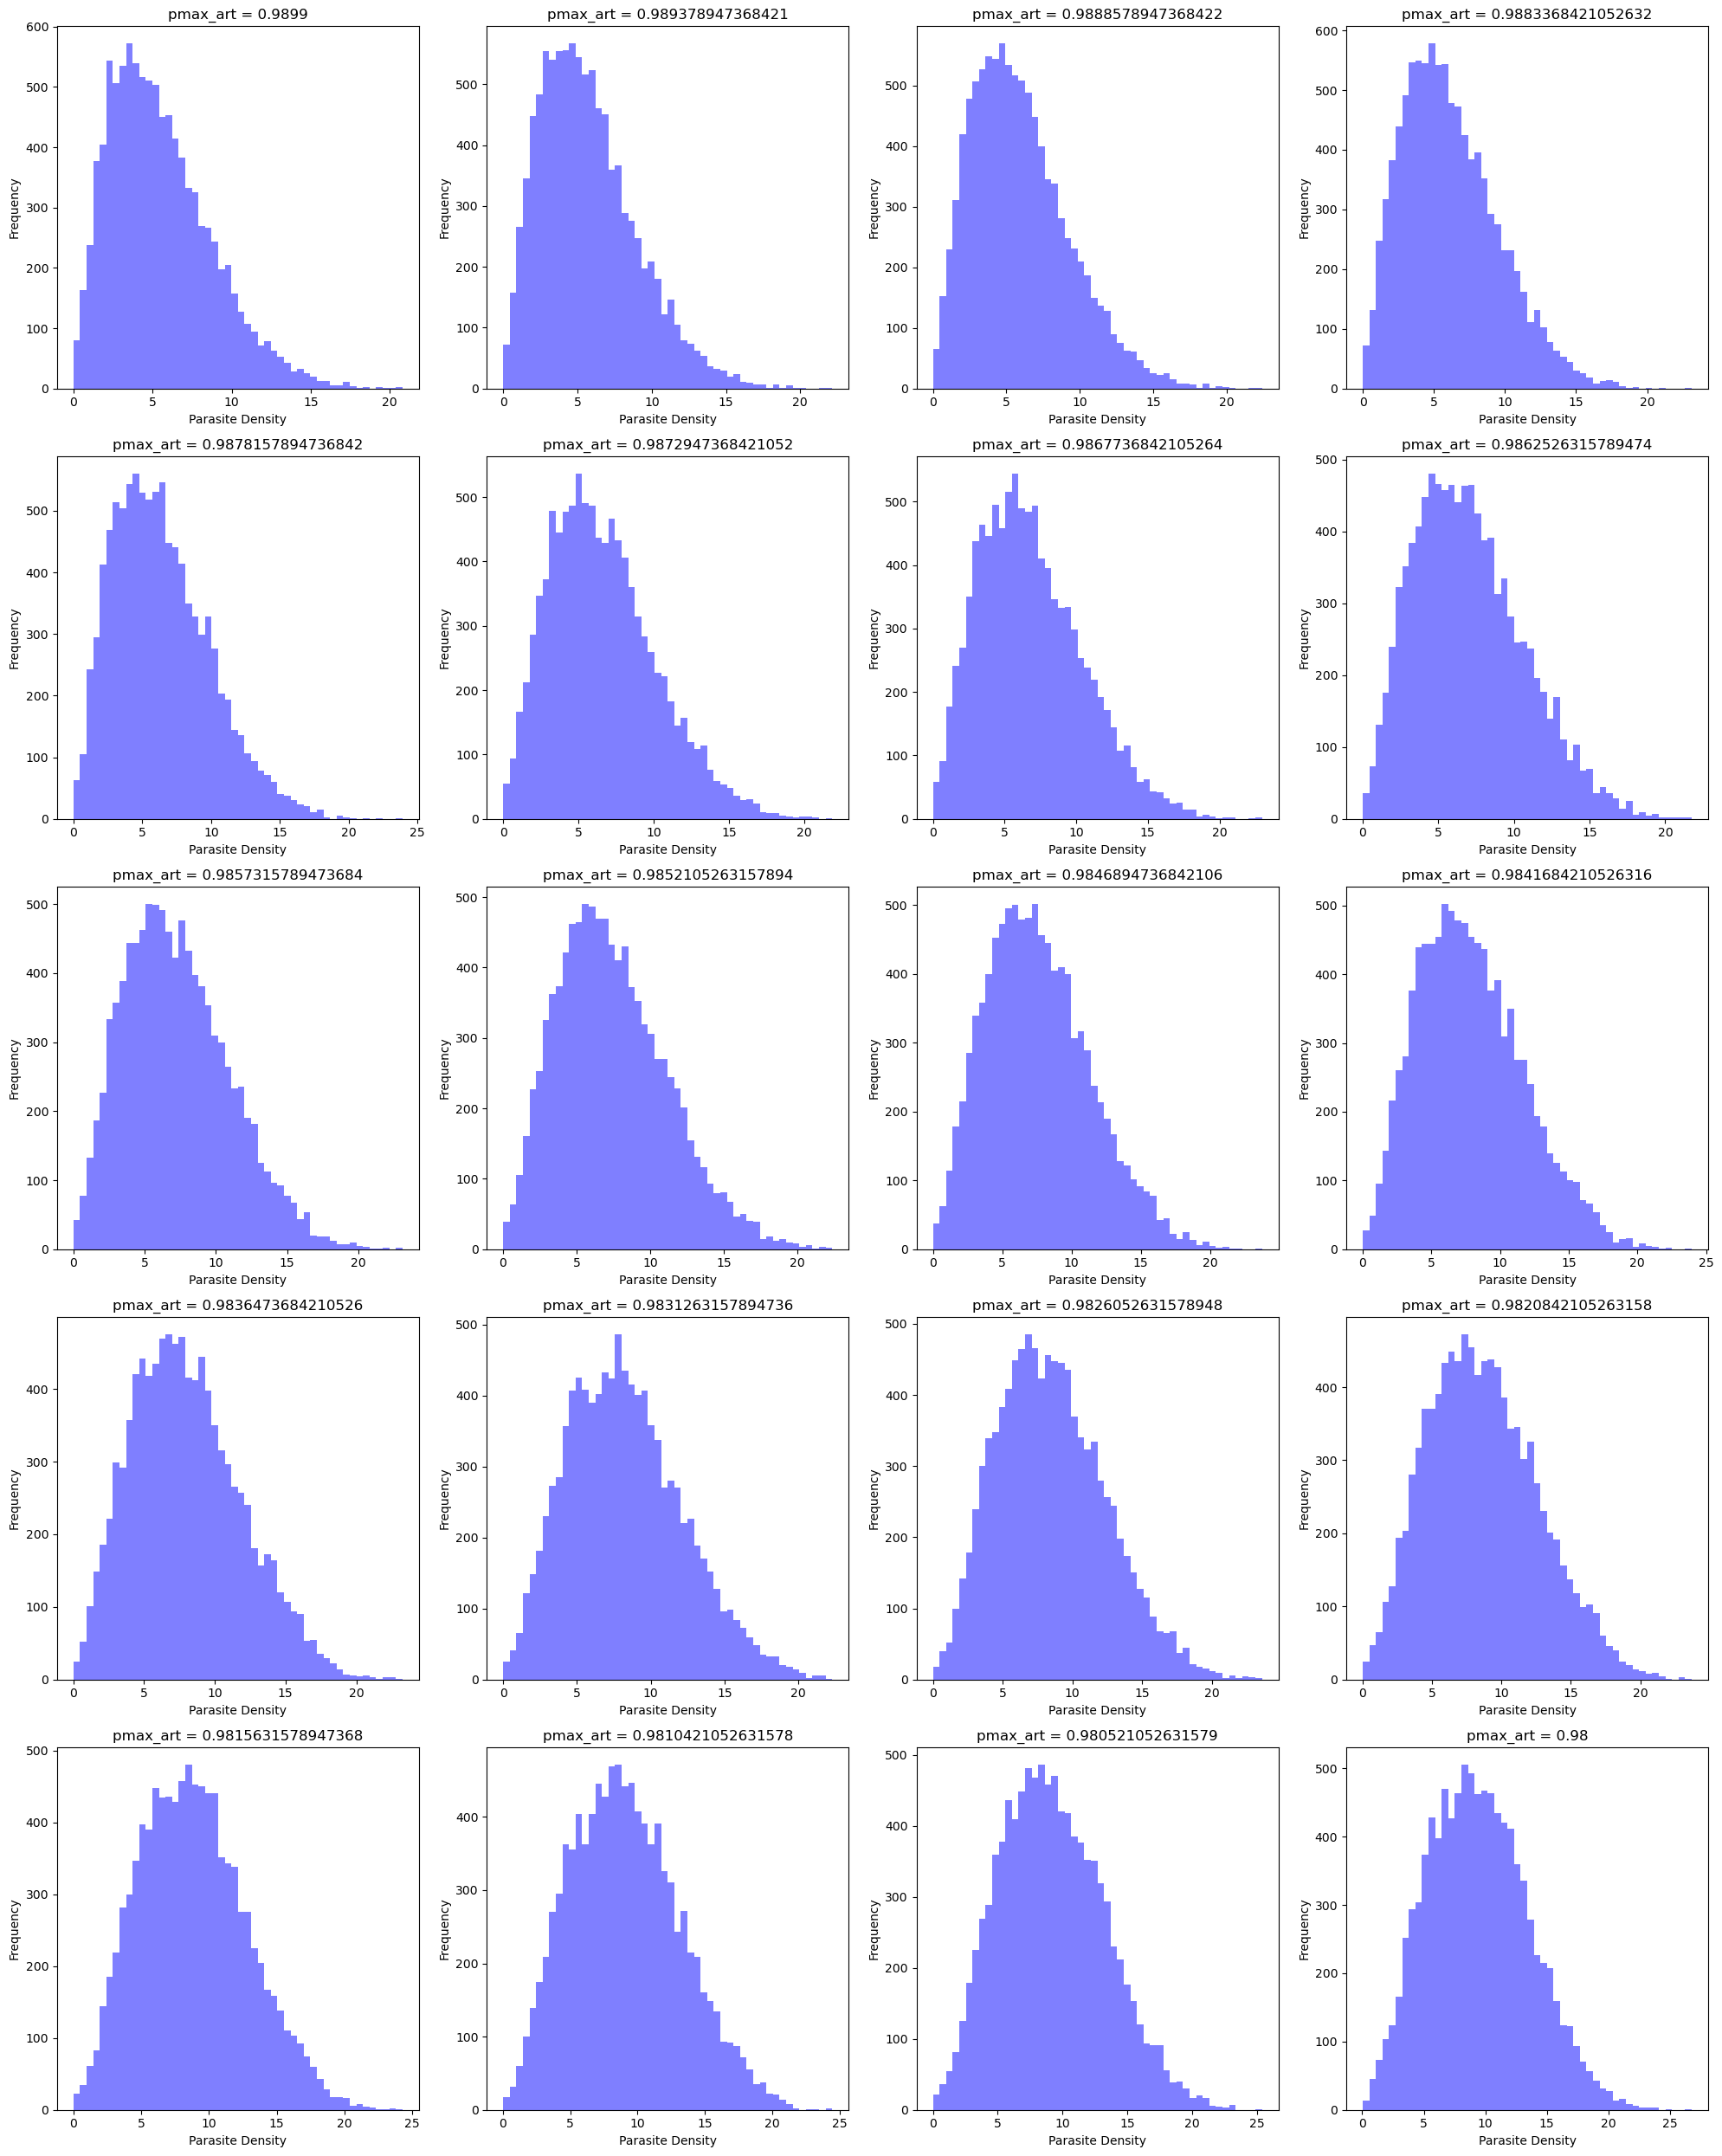

In [65]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))  # Create a 4x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i in range(20):
    ax = axes[i]
    dfs[i]['PARASITEDENSITY'].plot.hist(bins=50, alpha=0.5, color='b', ax=ax)
    ax.set_title(f'pmax_art = {pmax_values[i]}')
    ax.set_xlabel('Parasite Density')
    ax.set_ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig("pkpd_AL_pmax_art_test_05_parasite_density.png") 
plt.show()

In [ ]:
df_art = pd.read_csv("pkpd_AL_pmax_art_test_05_efficacy.csv")

pmax_vals =  np.array(df_art['pmax_art'])
efficacy_vals = np.array(df_art['efficacy'])
reqd_efficacy = 68.9

In [ ]:
# Sort the values
sorted_indices = np.argsort(efficacy_vals)
pmax_vals = pmax_vals[sorted_indices]
efficacy_vals = efficacy_vals[sorted_indices]

# Create an interpolation function
interp_func = interp1d(efficacy_vals, pmax_vals, kind='linear', fill_value="extrapolate")

# Find the corresponding pmax value for the required efficacy
pmax_value = interp_func(reqd_efficacy)

print(f"The pmax value for efficacy {reqd_efficacy} is {pmax_value}")

The pmax value for efficacy 68.9 is 0.9830586466165413
